# PyTorch computer Vision

Useful Modules
- `torchvision`
- `torchvision.datasets`
- `torchvision.models`
- `torchvision.transforms`
- `torchvision.utils.data.Dataset`
- `torchvision.utils.data.DataLoader`

In [ ]:
# Import torch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# import matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn

### Setting up Device Agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
torch.cuda.is_available()

In [ ]:
!nvidia-smi

### Loading the image data

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data= datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data= datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [ ]:
train_data.targets 

### Visualizing the data

In [ ]:
class_names = train_data.classes

In [ ]:
# torch.manual_seed(42)
fig= plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    rand_idx= torch.randint(0, len(train_data), size=[1]).item()
    img, label  = train_data[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

### Creating a Dataloader- to turn data into python iterable for batches

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
print(len(train_dataloader), len(test_dataloader))

In [ ]:
# Display image thorough Dataloader

train_features, train_labels= next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}\n")
print(f"Labels batch shape: {train_labels.size()}\n")

rand_idx = torch.randint(0, len(train_features), size=[1]).item()
img = train_features[rand_idx].squeeze()
label = train_labels[rand_idx]
plt.imshow(img, cmap="gray")
plt.axis(False)
plt.title(class_names[label])
plt.show()

### Model 0: Build a Baseline Model

In [ ]:
# Build a flatten layer
flatten_model = nn.Flatten()

x= train_features[0]

output = flatten_model(x)

print(f'Before Flattening {x.shape}\nAfter Flattening {output.shape}')

In [ ]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                input_shape:int,
                hidden_units:int,
                output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [ ]:
# torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)
model_0

In [ ]:
dummy_x = torch.rand([1,1,28,28]).to(device)
model_0(dummy_x)

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_function already exists")
else:
    print("Downloading the helper function")
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
    with open('helper_functions.py', "wb") as f:
        f.write(request.content)

In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [ ]:
### Creating a function to time our experiments
from timeit import default_timer as timer
def print_train_time(start:float,
                    end:float,
                    device: torch.device="cpu"):
    """Prints the difference between start time and end time"""
    total_time = end-start
    print(f'Train Time on {device}: {total_time:.3f} seconds')
    return total_time

### Creating a Training and Testing loop

In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)
s_time = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-----')
    # Training
    train_loss = 0
    # Add a loop to loop training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        X, y = X.to(device), y.to(device)
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples.")

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            X_test,y_test = X_test.to(device), y_test.to(device)
            test_pred = model_0(X_test)

            test_loss += loss_fn(test_pred, y_test)

            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        
        test_acc /= len(test_dataloader)
        
        if batch % 400 == 0:
            print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f} ")

e_time = timer()
total_time_model_0 = print_train_time(s_time, e_time, device='cpu')

In [ ]:
next(model_0.parameters()).device

In [ ]:
model_0.state_dict()

In [ ]:
# torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device=device
              ):
    """Return a Dictionary containing the results of model prediciting on data loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X.to(device))

            # Accumulate loss and accuracy
            loss +=  loss_fn(y_pred.to(device), y.to(device))
            acc  +=  accuracy_fn(y.to(device), y_pred.argmax(dim=1).to(device))

        # Scale loss and acc to find average loss/acc per batch
        loss /= len(data_loader)
        acc  /= len(data_loader)

    return {"model_name": model.__class__.__name__, 
            "model_loss": loss.item(),
            "model_acc":  acc}

model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn)
model_0_results

### Improving through Experimentation
- #### Building model with non-linearity
- #### GridSearchCV to find better values for hyperparameter 


In [53]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)



In [55]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [67]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(class_names) # number of output classes desired
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

In [68]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model_1.parameters(), lr=0.1)

### Creating a Function for Training and Testing loop

In [203]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)
        

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")



In [204]:
accuracy_fn

<function helper_functions.accuracy_fn(y_true, y_pred)>

In [205]:
# Measure time
from helper_functions import accuracy_fn
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)



  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.30166 | Train accuracy: 11.31%


 20%|█████████                                    | 1/5 [00:03<00:15,  3.77s/it]

Test loss: 2.30211 | Test accuracy: 10.75%

Epoch: 1
---------
Train loss: 2.30166 | Train accuracy: 11.31%


 40%|██████████████████                           | 2/5 [00:07<00:11,  3.68s/it]

Test loss: 2.30211 | Test accuracy: 10.75%

Epoch: 2
---------
Train loss: 2.30166 | Train accuracy: 11.31%


 60%|███████████████████████████                  | 3/5 [00:11<00:07,  3.75s/it]

Test loss: 2.30211 | Test accuracy: 10.75%

Epoch: 3
---------
Train loss: 2.30166 | Train accuracy: 11.31%


 80%|████████████████████████████████████         | 4/5 [00:14<00:03,  3.66s/it]

Test loss: 2.30211 | Test accuracy: 10.75%

Epoch: 4
---------
Train loss: 2.30166 | Train accuracy: 11.31%


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.74s/it]

Test loss: 2.30211 | Test accuracy: 10.75%

Train Time on cuda: 18.687 seconds


In [206]:
model_1_results = eval_model(model_1, test_dataloader,loss_fn, accuracy_fn)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 2.3021068572998047,
 'model_acc': 10.75279552715655}

## Building a CNN model

### Also known ad ConvNets
### CNN are known for their Capabilities to find pattern in visual data
https://poloclub.github.io/cnn-explainer/

In [217]:
# create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model Architecture that replicates the TinyVGG
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 =nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # also called output_layer or classifier layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # there's a trick to calculate this in_features, 
            # print output shape of both conv block and put H W of last block in output layer
            nn.Linear(in_features=hidden_units*7*7, 
                     out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f'Output shape of conv block 1: {x.shape}')
        x = self.conv_block_2(x)
        # print(f'Output shape of conv block 2: {x.shape}')
        x = self.classifier(x)
        # print(f'Output shape of classifier: {x.shape}')
        return x

In [218]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(
    input_shape=1,
    hidden_units=20,
    output_shape=len(class_names)
                    ).to(device)

In [219]:
rand_image = torch.randn(size=(1,28,28)).to(device)
model_2(rand_image.unsqueeze(0))
# rand_image.unsqueeze(0).shape

tensor([[-0.0850, -0.0175, -0.0502,  0.0433, -0.0013,  0.0395, -0.0038, -0.0309,
         -0.0619,  0.0125]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [220]:
torch.manual_seed(42)

# create a batch of images
images = torch.randn(size=(32,3,64,64))
test_image = images[0]

print(f'Image Batch size: {images.shape}')
print(f'Single Image size: {test_image.shape}')
print(f'Test Image: {test_image}')

Image Batch size: torch.Size([32, 3, 64, 64])
Single Image size: torch.Size([3, 64, 64])
Test Image: tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.79

In [221]:
# create a single Conv2d layer
torch.manual_seed(42)
conv_layer = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=(3,3),
    stride=1,
    padding=1
)

conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 64, 64])

In [222]:
torch.__version__

'2.5.1'

### Stepping through `nn.MaxPool2d()`

In [223]:
print(f'Test Original shape: {test_image.shape}')
print(f'Test image unsqueezed shape: {test_image.unsqueeze(0).shape}')

max_pool_layer = nn.MaxPool2d(kernel_size=2)

test_image_through_conv = conv_layer(test_image)
print(f'Test image after going through Conv2d layer: {test_image_through_conv.shape}')

test_image_through_conv_max_pool = max_pool_layer(test_image_through_conv)
print(f'Test image after going through Conv2d layer and max pool layer: {test_image_through_conv_max_pool.shape}')


Test Original shape: torch.Size([3, 64, 64])
Test image unsqueezed shape: torch.Size([1, 3, 64, 64])
Test image after going through Conv2d layer: torch.Size([10, 64, 64])
Test image after going through Conv2d layer and max pool layer: torch.Size([10, 32, 32])


In [224]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [225]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

epochs = 5
for epoch in tqdm(range(epochs)):
    print(f'-------Epoch: {epoch}------\n')
    train_step(model=model_2,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
               optimizer=optim,
              accuracy_fn=accuracy_fn,
              device=device)

    test_step(model=model_2,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

end_time = timer()
total_train_time_model_2 = print_train_time(start_time, end_time, device=device)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

-------Epoch: 0------

Train loss: 0.53972 | Train accuracy: 80.25%


 20%|█████████                                    | 1/5 [00:04<00:19,  4.99s/it]

Test loss: 0.36287 | Test accuracy: 87.15%

-------Epoch: 1------

Train loss: 0.32884 | Train accuracy: 88.07%


 40%|██████████████████                           | 2/5 [00:09<00:14,  4.79s/it]

Test loss: 0.31468 | Test accuracy: 88.60%

-------Epoch: 2------

Train loss: 0.28941 | Train accuracy: 89.56%


 60%|███████████████████████████                  | 3/5 [00:14<00:09,  4.88s/it]

Test loss: 0.29375 | Test accuracy: 89.59%

-------Epoch: 3------

Train loss: 0.26693 | Train accuracy: 90.51%


 80%|████████████████████████████████████         | 4/5 [00:19<00:04,  4.87s/it]

Test loss: 0.29592 | Test accuracy: 89.35%

-------Epoch: 4------

Train loss: 0.25159 | Train accuracy: 90.88%


100%|█████████████████████████████████████████████| 5/5 [00:24<00:00,  4.85s/it]

Test loss: 0.27271 | Test accuracy: 90.21%

Train Time on cuda: 24.249 seconds


In [226]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

In [227]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2727096974849701,
 'model_acc': 90.20567092651757}

In [88]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47885861992836,
 'model_acc': 83.52635782747603}

In [228]:
import pandas as pd
compare_results =  pd.DataFrame(
    [model_0_results, model_1_results, model_2_results]
)

compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.478859,83.526358
1,FashionMNISTModelV1,2.302107,10.752796
2,FashionMNISTModelV2,0.272710,90.205671


In [229]:
# Add training time to result comparison

compare_results["training_time"] = [total_time_model_0,
                                   total_train_time_model_1,
                                   total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.478859,83.526358,21.341236
1,FashionMNISTModelV1,2.302107,10.752796,18.687231
2,FashionMNISTModelV2,0.272710,90.205671,24.248846


Text(0, 0.5, 'model')

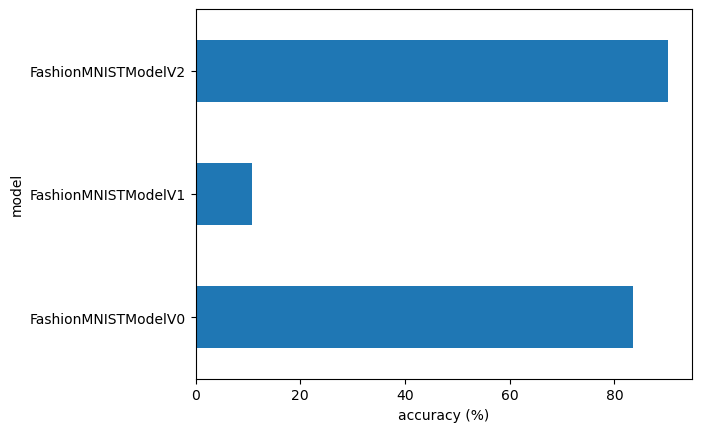

In [230]:
# Visulaize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind='barh')
plt.xlabel('accuracy (%)')
plt.ylabel('model')

## Make and Evalate random predictions with best model

In [231]:
def make_prediction(model: torch.nn.Module,
                   data: list,
                   device:torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logits = model(sample)

            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

            # gets pred_probs to cpu to calculate for matplotlib
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [232]:
img, labels = test_data[0][:10]
img.shape, labels

(torch.Size([1, 28, 28]), 9)

In [233]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Ankle boot')

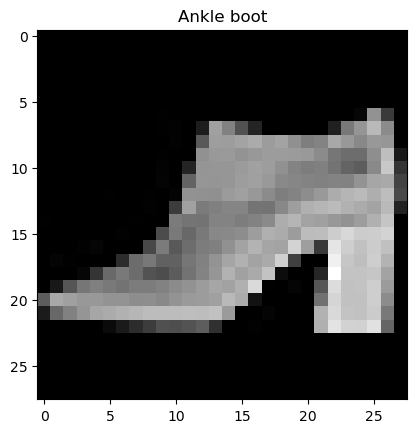

In [234]:
plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.title(class_names[test_labels[0]])

In [235]:
# Make predictions
pred_probs = make_prediction(model_2, data=test_samples)

# viee first two prediction probabilities
pred_probs[:2]

tensor([[5.4109e-08, 2.2030e-09, 1.7575e-08, 2.1911e-08, 2.7594e-08, 8.6103e-04,
         3.1698e-07, 1.1193e-06, 1.3705e-05, 9.9912e-01],
        [7.1801e-06, 3.4656e-06, 2.8113e-04, 1.3050e-07, 9.9949e-01, 3.2400e-08,
         2.0753e-04, 8.0055e-09, 9.8757e-06, 1.2064e-06]])

In [236]:
# convert prediction probability to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([9, 4, 2, 9, 7, 0, 4, 0, 5])

In [237]:
test_labels

[9, 4, 2, 9, 7, 6, 4, 0, 5]

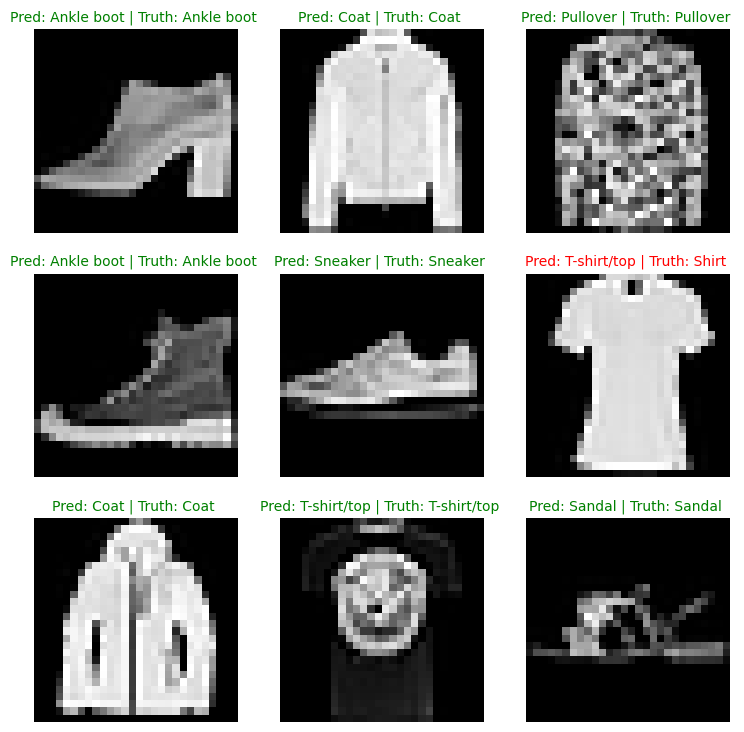

In [238]:
# Plot Predictions
plt.figure(figsize=(9,9))
n_rows = 3
n_cols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    
    title_text = f'Pred: {pred_label} | Truth: {truth_label} '
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')

    plt.axis(False)

## Making a Confusion Matrix for further evaluation

### mlxtend and torchmetrics are popular libraries for visualisation and evaluation of model resp

In [239]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="making predictions..."):
        X,y = X.to(device), y.to(device)
        y_logits = model_2(X)
        y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())

# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

making predictions...: 100%|█████████████████| 313/313 [00:00<00:00, 658.70it/s]


tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [240]:
len(y_pred_tensor)

10000

In [241]:
len(test_data.targets)

10000

## Plotting a Confusion Matrix

In [242]:
conda_env = 'pytorch_env'
try:
    import torchmetrics, mlxtend
    print(f'mlxtend version: {mlxtend.__version__}')
    assert int(mlxtend.__version__.split(".")[1]) >= 23, "mlxtend version should be 0.23.0 or higher"
except:
    !conda activate conda_env
    !conda install -c conda-forge torchmetrics
    !conda install -c conda-forge mlxtend
    import torchmetrics, mlxtend
    print(f'mlxtend version: {mlxtend.__version__}')
    

mlxtend version: 0.23.4


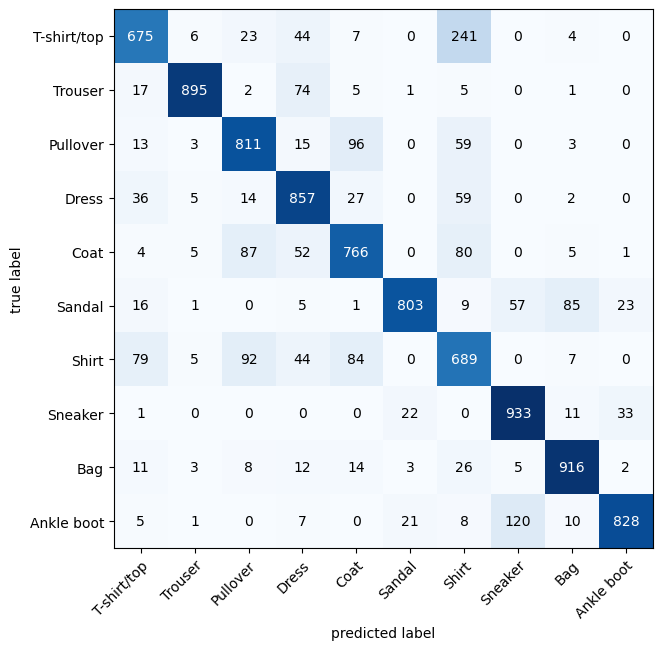

In [243]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# setup confusion matrix instance
confmat = ConfusionMatrix(
    task="multiclass",
    num_classes=len(class_names)
)

confmat_tensor = confmat(preds=y_pred_tensor, 
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

In [244]:
confmat_tensor

tensor([[675,   6,  23,  44,   7,   0, 241,   0,   4,   0],
        [ 17, 895,   2,  74,   5,   1,   5,   0,   1,   0],
        [ 13,   3, 811,  15,  96,   0,  59,   0,   3,   0],
        [ 36,   5,  14, 857,  27,   0,  59,   0,   2,   0],
        [  4,   5,  87,  52, 766,   0,  80,   0,   5,   1],
        [ 16,   1,   0,   5,   1, 803,   9,  57,  85,  23],
        [ 79,   5,  92,  44,  84,   0, 689,   0,   7,   0],
        [  1,   0,   0,   0,   0,  22,   0, 933,  11,  33],
        [ 11,   3,   8,  12,  14,   3,  26,   5, 916,   2],
        [  5,   1,   0,   7,   0,  21,   8, 120,  10, 828]])

## Saving & Load our best model

In [245]:
from pathlib import Path

# create model path
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model name
MODEL_NAME = '03_pytorch_cv_model_3.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save model state_dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(
    obj=model_2.state_dict(),
    f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_cv_model_3.pth


In [251]:
image_shape = [1, 28, 28]

In [253]:
# create nwe instance of model_3
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                    hidden_units=20,
                                    output_shape=len(class_names))

# load in the save dicts
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# sent the model to target device
loaded_model_2.to(device)

/tmp/ipykernel_9296/3173504275.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=980, out_features=10, bias=True)
  )
)

In [254]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2727096974849701,
 'model_acc': 90.20567092651757}

In [256]:
# Evaluate loaded model
torch.manual_seed(42)
loaded_model_2_result = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device)

In [257]:
loaded_model_2_result

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2727096974849701,
 'model_acc': 90.20567092651757}

In [258]:
# check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
             torch.tensor(loaded_model_2_result["model_loss"]),
             atol=1e-02)

tensor(True)

In [260]:
# check if model results are close to each other
torch.isclose(torch.tensor(model_1_results["model_loss"]), #
             torch.tensor(loaded_model_2_result["model_loss"]),
             atol=1e-02)

tensor(False)